In [6]:
%reload_ext autoreload
%autoreload 2

import os
import torch
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from pathlib import Path
import os
import torch
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
from scipy import interpolate
#from sklearn.preprocessing import normalize
from pathlib import Path
import json
import cv2
import matplotlib.pyplot as plt
import random

with open("3_stroke_16_v2/train_online_coords.json") as f:
    
    output_dict = json.load(f)


In [227]:


## Other loss functions and variations
# Distance from actual point
# Distance to nearest point on image
# Minimal penalty for first/last stroke points
# Make it probabilistic? I.e. there's some probability it starts at the top or bottom
# Compare rendered images! How to make it differentiable?
# Handle empty time differently - have computer guess "in between" stroke value? could work
# Stroke level penalties - perfect inverse/backward patterns have minimal penalty
# Need an end of stroke and end of sequence token - small penalty if end of stroke is close

## Other ideas
# Feed in current "step" to RNN, scaled to same scale as width

# Add more instances -- otherwise make it so the first instance is at the start of the letter

pad_dpi = {"padding":.05, "dpi":71}

def prep_figure(dpi=71):
    plt.figure(figsize=(1, 1), dpi=dpi)
    plt.axis('off')
    plt.axis('square')

def draw_strokes(stroke_list, x_to_y=1, line_width=None, save_path=""):
    # plt.NullFormatter()
    if save_path:
        prep_figure(pad_dpi["dpi"])
    if line_width is None:
        line_width = max(random.gauss(1, .5), .4)

    if x_to_y != 1:
        for stroke in stroke_list:
            stroke["x"] = [item * x_to_y for item in stroke["x"]]

    for stroke in stroke_list:
        plt.plot(stroke["x"], stroke["y"], linewidth=line_width, color="black")

    y_min = min([min(x["y"]) for x in stroke_list])
    y_max = max([max(x["y"]) for x in stroke_list])
    x_min = min([min(x["x"]) for x in stroke_list])
    x_max = max([max(x["x"]) for x in stroke_list])

    plt.ylim([y_min, y_max])
    plt.xlim([x_min, x_max])
    # print(y_min, y_max, x_min, x_max)
    if save_path:
        plt.savefig(save_path, pad_inches=pad_dpi["padding"], bbox_inches='tight')
        plt.close()




def get_strokes(path, max_stroke_count=None):
    """
    Args:
        path: XML path to stroke file

    Returns:
        list of lists of dicts: each dict contains a stroke, keys: x,y, time
    """
    root = ET.parse(path).getroot()
    all_strokes = root[1]
    stroke_lists = []
    start_end_strokes_lists = []

    # If not constrained by number of strokes, set max_stroke_count to full length window
    if max_stroke_count is None:
        max_stroke_count = len(all_strokes) - 1
    
    for i in range(len(all_strokes) - max_stroke_count):
        strokes = all_strokes[i:i + max_stroke_count]
        stroke_list = []
        min_time = float(strokes[0][0].attrib["time"])
        last_time = 0
        stroke_delay = 0  # time between strokes
        start_end_strokes = [] # list of start times and end times between strokes; one before sequence starts!
        
        for stroke in strokes:
            x_coords = []
            y_coords = []
            time_list = []

            for i, point in enumerate(stroke):
                # print("Points", len(strokes))
                x, y, time = point.attrib["x"], point.attrib["y"], point.attrib["time"]
                x_coords.append(int(x))
                y_coords.append(-int(y))

                if i == 0:  # no time passes between strokes!
                    min_time += float(time) - min_time - last_time - .001
                    start_end_strokes.append((last_time, float(time) - min_time))

                next_time = float(time) - min_time

                if time_list and next_time == time_list[-1]:
                    next_time += .001
                    assert next_time > time_list[-1]

                # No repeated times
                if time_list and next_time <= time_list[-1]:
                    next_time = time_list[-1] + .001

                time_list.append(next_time)
            last_time = time_list[-1]
            stroke_list.append({"x": x_coords, "y": y_coords, "time": time_list})

        stroke_lists.append(stroke_list)
        start_end_strokes_lists.append(start_end_strokes)
        
    return stroke_lists, start_end_strokes_lists


def convert_strokes(stroke_list):
    """ Convert the stroke dict to 3 lists

    Args:
        stroke_list (list): list of dicts, each dict contains a stroke, keys: x,y, time
    Returns:
        tuple of array-likes: x coordinates, y coordinates, times

    """
    x, y, time = [], [], []
    [x.extend(key["x"]) for key in stroke_list]
    [y.extend(key["y"]) for key in stroke_list]
    [time.extend(key["time"]) for key in stroke_list]
    return np.array(x), np.array(y), np.array(time)


def process(time):
    total_time = np.max(time) - np.min(time)

def normalize(my_array, _max=1):
    """ Max/min rescale to -1,1 range

    Args:
        my_array:

    Returns:

    """
    return ((my_array - np.min(my_array)) / array_range(my_array) - .5) * 2 * _max

def array_range(my_array):
    return np.max(my_array)-np.min(my_array)

def normalize_stroke_list(stroke_list, maintain_ratio=False):
    """ Max/min rescale to -1,1 range

    Args:
        my_array:

    Returns:

    """
    x_max = np.max([max(x["x"]) for x in stroke_list])
    x_min = np.min([min(x["x"]) for x in stroke_list])
    y_min = np.min([min(x["y"]) for x in stroke_list])
    y_max = np.max([max(x["y"]) for x in stroke_list])

    ## THIS DOES NOT MAINTAIN CENTERING!
    if maintain_ratio:
         xrange = x_max-x_min
         yrange = y_max-y_min
         x_max = xrange * yrange/xrange + x_min


    new_stroke_list = []
    for item in stroke_list:
        #print(item["x"])
        new_stroke_list.append({"x":normalize(item["x"].copy(), x_max, x_min), "y":normalize(item["y"].copy(), y_max, y_min)})

    return new_stroke_list


def extract_gts(path, instances = 50, max_stroke_count=None):
    """ Take in xml with strokes, output ordered target coordinates
        Parameterizes x & y coordinates as functions of t
        Any t can be selected; strokes are collapsed so there's minimal time between strokes

        Start stroke flag - true for first point in stroke
        End stroke flag - true for last point in stroke
        ** A single point can have both flags!

    Args:
        path (str): path to XML
        instances (int): number of desired coordinates

    Returns:
        x-array, y-array
    """
    stroke_lists, start_end_strokes_lists = get_strokes(path, max_stroke_count=max_stroke_count)
    
    output_gts = []
    output_stroke_lists = []
    output_xs_to_ys = []

    for stroke_list, start_end_strokes in zip(stroke_lists, start_end_strokes_lists):
        x,y,time = convert_strokes(stroke_list)

        # find dead timezones
        # make x and y independently a function of t
        time_continuum = np.linspace(np.min(time), np.max(time), instances)
        x_func = interpolate.interp1d(time, x)
        y_func = interpolate.interp1d(time, y)
        begin_stroke = []
        start_end_strokes_backup = start_end_strokes.copy()

        # Each time a stop/start break is met, we've started a new stroke
        # We start with a stop/start break
        end_stroke_override = False

        strokes_left = len(start_end_strokes)
        for i,t in enumerate(time_continuum):
            for ii, (lower, upper) in enumerate(start_end_strokes):
                if t < lower:
                    break # same stroke, go to next timestep
                elif t > lower and t < upper:
                    if abs(t-lower) < abs(t-upper):
                        t = lower
                    else:
                        t = upper
                    time_continuum[i] = t
                if t >= upper: # only happens on last item of stroke
                    start_end_strokes = start_end_strokes[ii+1:]
                    break

            # Don't use strokes that can't help anymore
            #print(len(start_end_strokes), len(start_end_strokes[ii:]), start_end_strokes)

            if strokes_left > len(start_end_strokes):
                strokes_left = len(start_end_strokes)
                begin_stroke.append(1)
            else:
                begin_stroke.append(0)


        end_stroke = begin_stroke.copy()[1:] + [1]
        begin_stroke = np.array(begin_stroke)
        end_stroke = np.array(end_stroke)
        end_of_sequence = np.zeros(time_continuum.shape[0])
        end_of_sequence[-1] = 1

        # print(end_of_sequence.shape, end_stroke.shape, begin_stroke.shape)
        # print(begin_stroke)
        # print(end_stroke)
        # print(end_of_sequence)

        x_range = array_range(x_func(time_continuum))
        y_range = array_range(y_func(time_continuum))

        assert len(normalize(x_func(time_continuum))) == len(normalize(y_func(time_continuum))) == len(begin_stroke) == len(end_stroke) == len(end_of_sequence)
        output = np.array([normalize(x_func(time_continuum)), normalize(y_func(time_continuum)), begin_stroke, end_stroke, end_of_sequence])

        output_gts.append(output)
        output_stroke_lists.append(stroke_list)
        output_xs_to_ys.append(x_range/y_range)

    return output_gts, output_stroke_lists, output_xs_to_ys
def render_points_on_image(gts, img_path, strokes=None, save_path=None, x_to_y=None):
    gts = np.array(gts)

    if x_to_y is not None:
        print("x to y ratio: ", x_to_y)
        gts[0] *= x_to_y

    x = gts[0]
    y = gts[1]
    start_points = gts[2]

    # prep_figure()
    if strokes:
        draw_strokes(normalize_stroke_list(strokes), x_to_y=x_to_y)
    elif img_path:
        img_path = img_path.replace("online_coordinate_data/", "")
        img_path = Path(img_path)
        img = cv2.imread(img_path.as_posix(), cv2.IMREAD_GRAYSCALE)
        img = img[::-1, :]
        img = cv2.resize(img, (60, 60))
        plt.imshow(img, cmap="gray")
        
        # move to to 1 by 1
        # squareify it first (1 by 1)
        # then apply padding
        # then scale up by 60
        x -= min(x)
        y -= min(y)
        x /= max(x)
        y /= max(y)
        x += pad_dpi["padding"]
        y += pad_dpi["padding"]
        #scale_factor = pad_dpi["padding"] * 2
        
        #x = x / (max(x) + scale_factor)
        #y = y / (max(y) + scale_factor)
        x *= 54.7 
        y *= 55

        # Rescale points
        #factor = 2 * pad_dpi["padding"] + 1
        #x = (x) / 2 * 60 / factor + pad_dpi["padding"] * 60 / 2
        #y = (y) / 2 * 60 / factor + pad_dpi["padding"] * 60 / 2

    x_middle_strokes = x[np.where(start_points == 0)]
    y_middle_strokes = y[np.where(start_points == 0)]
    x_start_strokes = x[np.where(start_points == 1)]
    y_start_strokes = y[np.where(start_points == 1)]

    plt.scatter(x_middle_strokes, y_middle_strokes, s=4)
    plt.scatter(x_start_strokes, y_start_strokes, s=4)

    for (x1, y1), (x2, y2) in zip(zip(x_middle_strokes, y_middle_strokes), 
                                  zip(x_middle_strokes[1:], y_middle_strokes[1:])):
        xdiff = (x2 - x1)
        ydiff = (y2 - y1)
        dx = xdiff / math.sqrt(xdiff**2 + ydiff**2) / 10
        dy = ydiff / math.sqrt(xdiff**2 + ydiff**2) / 10
        plt.arrow(x1, y1, dx, dy, color="blue", head_width = 0.04, head_length = 0.03, length_includes_head = True)

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        print("final show")
        plt.show()


x to y ratio:  1.3085440874827543
final show


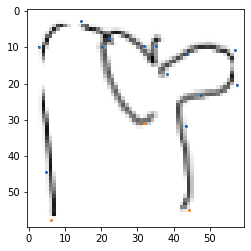

In [228]:
## Render points on strokes
instance = output_dict[10]
#render_points_on_image(instance['gt'], img_path=instance['image_path'], strokes=instance["stroke_list"], x_to_y=instance["x_to_y"])
render_points_on_image(instance['gt'], img_path=instance['image_path'], x_to_y=instance["x_to_y"])

final show


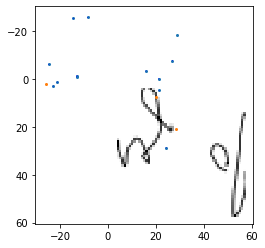

In [37]:
## Render points on image

render_points_on_image(instance['gt'], img_path=instance['image_path'])

In [83]:
x = np.array(instance['gt'])
[len(m) for m in x]

[50, 50, 50, 50, 50]

In [86]:
idx = np.where(x[2]==1)
x[1][idx]

array([0.88908817, 0.77899161, 0.47210899])

In [105]:
normalize_stroke_list(instance["stroke_list"])

[1035, 1055, 1055, 1057, 1061, 1066, 1071, 1076, 1078, 1083, 1086, 1083, 1086]
[965, 960, 968, 994, 1023, 1055, 1094, 1124, 1149, 1162, 1172, 1165, 1156, 1150, 1155, 1164, 1185, 1208, 1228, 1249, 1268, 1279, 1286, 1281, 1269, 1252, 1228, 1199, 1170, 1143, 1121, 1107, 1096]
[1363, 1363, 1366, 1370, 1371, 1380, 1387, 1399, 1419, 1442, 1467, 1493, 1510, 1522, 1529, 1537, 1544, 1549, 1551, 1550, 1542, 1528, 1517, 1498, 1471, 1438, 1405, 1371, 1343, 1322, 1314, 1310, 1312, 1314, 1317, 1330, 1348]


[{'x': [-0.7461928934010152,
   -0.6785109983079527,
   -0.6785109983079527,
   -0.6717428087986463,
   -0.6582064297800339,
   -0.6412859560067682,
   -0.6243654822335025,
   -0.607445008460237,
   -0.6006768189509306,
   -0.583756345177665,
   -0.5736040609137056,
   -0.583756345177665,
   -0.5736040609137056],
  'y': [0.8865248226950355,
   0.8120567375886525,
   0.7730496453900708,
   0.698581560283688,
   0.6134751773049645,
   0.5283687943262412,
   0.44326241134751765,
   0.37234042553191493,
   0.3156028368794326,
   0.25886524822695045,
   0.2021276595744681,
   0.17375886524822692,
   0.13120567375886516]},
 {'x': [-0.9830795262267343,
   -1.0,
   -0.9729272419627749,
   -0.8849407783417935,
   -0.7868020304568528,
   -0.6785109983079527,
   -0.5465313028764806,
   -0.44500846023688667,
   -0.36040609137055835,
   -0.3164128595600677,
   -0.2825719120135364,
   -0.3062605752961083,
   -0.33671742808798644,
   -0.3570219966159053,
   -0.3401015228426396,
   -0.3096446700507614

In [41]:
np.where(x[2])

(array([ 0,  8, 27]),)

In [48]:
x[1][x[2]]

TypeError: list indices must be integers or slices, not list

list

In [264]:
normalize(np.array(range(0,9)))

/home/taylor/anaconda3/envs/hw2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

101.33333333333334

In [359]:
import sys
sys.path.append("../..")
from models.basic import CNN
from torch import Tensor
cnn = CNN(nc=1)
my_image = Tensor(np.array(range(0,3600)).reshape(1,1,60,60))

output = cnn(my_image)
print(output.shape)

Intermediate pass None
torch.Size([16, 1, 1024])


In [366]:
data_folder = Path("..").resolve()
path = Path("/media/data/GitHub/simple_hwr/data/online_coordinate_data/3_stroke_16/")
path.relative_to(data_folder)

PosixPath('online_coordinate_data/3_stroke_16')